## configuration instead of code

This notebook will develop some ideas about a configuration system to describe models in a simple format that encourages exchange between users and long term usability.  Many concepts are derived from conventions in the Thinc library, and we want to take a compositional approach: if the built in simulator loop isn't approach, use config components just for the model building to save time.  Some use cases to keep in mind, but not all implement at once

- field models (R^3 & S^2)
- multiple possibly high res connectomes
- flexible stimulation (not just TVB-style)
- mixed subcortical cortical models e.g. JR here, MPR there, etc
- library of reusable components
- flexible full model spec + debugging tools
- multiscale / cosim

We start by assuming the target model usage can be described roughly as a tree, e.g. 

- exec
  - number of cores
  - data source
  - sbatch array / daskiness
  - etc
- data
  - connectivity
  - surface
  - subcortical volumes
  - time series
      - preprocessing e.g. FFT or FCD
- model
  - integration scheme
  - global DE
    - coupling/connectivity components
    - aux equations
    - DE RHSs in sympy-digestible form
        - could be grouped e.g. JR w/ a spatial mask
  - forward models ("monitors")
    - e.g. BOLD has it's own equations & integrator
  - postprocessing e.g. FFT or FCD, to match data preprocessing
- stats/fit
  - parameter & prior combinations
  - inference method (map, vi, nuts) + config
  - post processing / diagnostics

In the following we'll try to prototype this with [confection](https://github.com/explosion/confection) for the neural field inference developed in [a sibling notebook](60%20First%20field%20in%20numpyro.ipynb), taking advantage of the function registry to check types and avoid as much ad-hoc code as possible.  As it develops, we push code into the Python library.  It may be useful to use Pydantic for sanity checking, cf [this write up](https://medium.com/swlh/cool-things-you-can-do-with-pydantic-fc1c948fbde0).

## getting started

First off we define a registry,

In [1]:
%pylab inline
import numpy as np
import numpy.typing as npt
import functools
import catalogue
from confection import registry, Config

registry.legos = catalogue.create("confection", "legos", entry_points=False)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## convenience functions

To debug registered function calls, we'll set up our own decorator for registration and a shortcut to eval a config,

In [13]:
def new_lego(name=None):
    def wrapper(wrapped):
        @registry.legos.register(name or wrapped.__name__)
        @functools.wraps(wrapped)
        def f(*args, **kwargs):
            print(f'invoking {wrapped}')
            return wrapped(*args, **kwargs)
        return f
    return wrapper

def eval_config(s):
    return registry.resolve(Config().from_str(s))

## defining config APIs

with that bit of bureaucracy we can do the following,

In [3]:
@new_lego()
def make_shtdiff(lmax: int, nlat: int, nlon: int, D: float=0.0004) -> np.ndarray[np.float32]:
    """Computes a precomputed spherical harmonic transform-based diffusion
    coupling function.
    
    Parameters
    ----------
    lmax
        Truncation order for the spherical harmonic series, `lmax` < `nlat`.
    nlat
        Number of latitudes for the regular spherical grid.
    nlon
        Number of longitudes for the regular spherical grid.
    D
        Scaling of the diffusion, default value of `4e-4` based on r=10 cm
        inflated cortical surface.
    
    Returns
    -------
    L
        A 3-D array where each `L[m]` matrix provides the Legendre transform
        for the `m`th longitudinal frequency
    
    """
    import nfjax.shtlc as lc
    if lmax >= nlat:
        lmax = nlat - 1
    _, L = lc.make_shtdiff(lmax=lmax, nlat=nlat, nlon=nlon, D=D, return_L=True)
    np.testing.assert_equal(0, L.imag)
    L = L.real.astype('f')
    return L

@new_lego()
def randn_init(nlat: int, nlon: int) -> np.ndarray[np.float32]:
    "Generate random initial state."
    return np.random.randn(nlat, nlon)

@new_lego()
def apply_shtdiff(L: np.ndarray[np.float32], x: np.ndarray[np.complex64]) -> np.ndarray[np.complex64]:
    """Computes the spherical harmonic transform using precomputed Legendre transforms.
    
    
    """
    lmax = L.shape[0]
    X = np.fft.rfft(x, axis=1)
    X = np.hstack(
        (np.einsum('abc,ca->ba', L, X[:,:lmax]),
         np.zeros((X.shape[0], X.shape[1] - lmax), np.complex64)
        )
    )
    y = np.real(np.fft.irfft(X, axis=1))
    return y

These functions provide a Python API usable from regular code but since they are registered, they can be invoked via the configuration system,

invoking <function make_shtdiff at 0x11b4ef7f0>
invoking <function randn_init at 0x11b4ef640>
invoking <function make_shtdiff at 0x11b4ef7f0>
invoking <function randn_init at 0x11b4ef640>
invoking <function apply_shtdiff at 0x11b4ef910>


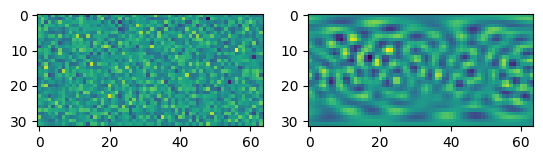

In [14]:
res = eval_config('''
[lc]
@legos = make_shtdiff
lmax = 17
nlat = 32
nlon = 64

[x0]
@legos = randn_init
nlat = ${lc.nlat}
nlon = ${lc.nlon}

[x1]
@legos = apply_shtdiff
L = ${lc}
x = ${x0}
''')

subplot(121); imshow(res['x0'])
subplot(122); imshow(res['x1'])

From this we see a few things

- no code to write to map parsed config to functions
- data flow is defined using back references to other config sections
- back refs allow not repeating details like `nlat`

## math expressions

are important to get right not just stringly typed stuff, let's use SymPy as the validation barrier for that sort of thing, even if that's not the whole solution,

In [24]:
@new_lego()
def ode(name: str, rhs: str):
    import sympy
    return sympy.sympify(name), sympy.sympify(rhs)

ode('x', 'x - x**3/3')

invoking <function ode at 0x127368af0>


(x, -x**3/3 + x)

In [26]:
res = eval_config('''
[bistable]
@legos = ode
name = x
rhs = x - x**3/3
''')

res['bistable'][1].diff(res['bistable'][0])

invoking <function ode at 0x127368af0>


1 - x**2

With this, some basic validation of ODEs w/ e.g. linear stability analysis is possible (was never done in TVB)

## partial evaluation

For this to scale up we'll need to be able to configure partially evaluated functions to pass into other functions as components to evaluate.  The `apply_shtdiff` above is an example: we want to curry that function with an `L` specified in the config,

In [23]:
@new_lego()
def apply_shtdiff_L(L: np.ndarray[np.float32]):
    return lambda x: apply_shtdiff(L, x)

and let another section of the config specify that as a component to use along with which variable to apply it to.  For instance, for full field simulation, we need two spheres.  Instead of packing into a single array we can collect multiple arrays into a dict, `model.states` here, as a namespace for inter-component data flow. In other words we can exploit the fact that if we don't provide a `@lego = name` function to invoke, the result is a dictionary to structure elements:

In [29]:
res = eval_config('''
[lc]
@legos = make_shtdiff
lmax = 17
nlat = 32
nlon = 64

[apply_lc]
@legos = apply_shtdiff_L
L = ${lc}

[model]

[model.states]
[model.states.lh_x]
@legos = randn_init
nlat = ${lc.nlat}
nlon = ${lc.nlon}

[model.states.rh_x]
@legos = randn_init
nlat = ${lc.nlat}
nlon = ${lc.nlon}

[model.parts]
[model.parts.lh_cfun]
func = ${apply_lc}
var = lh_x

[model.parts.rh_cfun]
func = ${apply_lc}
var = rh_x

[model.parts.lh_dfun]
@legos = ode
name = x
rhs = x - x**3/3

[model.parts.rh_dfun]
@legos = ode
name = x
rhs = x - x**3/3 + 0.1
''')

res['model']

invoking <function make_shtdiff at 0x11b4ef7f0>
invoking <function apply_shtdiff_L at 0x12736b910>
invoking <function make_shtdiff at 0x11b4ef7f0>
invoking <function make_shtdiff at 0x11b4ef7f0>
invoking <function apply_shtdiff_L at 0x12736b910>
invoking <function ode at 0x127368af0>
invoking <function make_shtdiff at 0x11b4ef7f0>
invoking <function apply_shtdiff_L at 0x12736b910>
invoking <function ode at 0x127368af0>
invoking <function randn_init at 0x11b4ef640>
invoking <function randn_init at 0x11b4ef640>


{'parts': {'lh_cfun': {'func': <function __main__.apply_shtdiff_L.<locals>.<lambda>(x)>,
   'var': 'lh_x'},
  'lh_dfun': (x, -x**3/3 + x),
  'rh_cfun': {'func': <function __main__.apply_shtdiff_L.<locals>.<lambda>(x)>,
   'var': 'rh_x'},
  'rh_dfun': (x, -x**3/3 + x + 0.1)},
 'states': {'lh_x': array([[ 0.49464704, -1.9887687 , -0.19436942, ...,  1.05379302,
          -0.35645117, -0.92892445],
         [-1.15855378,  1.83809793,  0.20433019, ...,  0.24057663,
          -1.38306221, -1.47846749],
         [ 0.49622241, -0.681251  , -0.14935246, ..., -0.41696251,
           1.7646266 , -1.09548935],
         ...,
         [-0.92764378, -0.22434343,  0.35807178, ...,  1.28631334,
          -0.51258725, -0.20232653],
         [-0.37791256, -0.28882325, -0.55281562, ...,  0.88238885,
          -1.42804077, -0.8153128 ],
         [ 1.77279105, -0.16251772, -0.80492029, ...,  0.9540087 ,
           1.499249  , -0.50707662]]),
  'rh_x': array([[ 2.50804722,  0.09588865, -0.50444769, ..., -0.4

A generic evaluator can step through the elements of the `model` dict, evaluating parts.  Performance wise, it's probably just as fast or faster than masking/indexing parts of a single large array, but it scales up in model complexity without complex code.  A Jax version would flatten the whole dict on JIT.

###### minor note on how to order components!

How to schedule model components?

In [30]:
type(res['model'])

dict

a plain `dict` provides no information about the dependencies among components, so we can use a `dict` subclass that serves as a namespace to evaluate dependencies and cache them, which once traced, can yield the right order.

In other words, for a given `dict` returned from a configuration, which defines all the components involved, we can loop through all the keys, check if the value is callable or not.  If it's not a callable, we assume the term is evaluated and final, i.e. an `np.ndarray`.  If it's callable, we assume it's to be evaluated and call it with the `dict` as an argument, then replace `dict[{key}]` with the result of the callable.  In the callable, it will try to `dict.__getitem__` which result in recursive traversal of the dependency graph and computation of all values in the `dict`.  This evaluated `dict` is then the result which is referred to by other siblings elements of the config.

In [ ]:
# 
class Interp(dict):
    
    def eval_key(self, key):
        # callables are thunks lazing about prior to evaluation
        if hasattr(self[key], '__call__'): # TODO use a better distinction
            self[key] = self[key](self)
        return self[key]
    
    def eval_all(self):
        all_keys = self.keys()
        for key in all_keys:
            self[key]

This is not tested code! *TODO* example functions + config

Since this can be applied anywhere in the config, it means we can config arbitrary complexity graph of stuff, or extra flexibility we don't currently have in TVB (e.g. do full simulation then compute BOLD vs compute BOLD online: both can be expressed in this config system, not hard coded).  As long as it gets traced by a JIT at some point, there should be no performance worries (and rev mode autodiff is a graph traversal thing anyway).

## ordering fields

If we really need to preserve order, then this list form is required:

In [39]:
eval_config('''
[box]

[box.*.thing1]
name = 0230402304

[box.*.thing2]
name = Foo bar

[box.*.thing3]
name = Doggo
''')['box']['*']

[{'name': 230402304}, {'name': 'Foo bar'}, {'name': 'Doggo'}]

## multifile configs

seems trivial but good to anticipate (a) the pain point of a giant monolithic copy pasta accident and (b) reusability.

One use case is taking a base/default config and sprinkling in some opinions:

In [41]:
base_config = Config().from_str('''
[mpr]
bar = baz
J = -4.7
dt = 0.1
tau = 1.0
''')

opinions = Config().from_str('''
[mpr]
dt = 0.3
tau = 10.0
''')

base_config.copy().merge(opinions)

{'mpr': {'dt': 0.30000000000000004, 'tau': 10.0, 'bar': 'baz', 'J': -4.7}}

*TODO* multifile config with a loader function, but it's kinda trivial.

## batching

While it's helpful to express the model in terms of components, it may be useful in some cases to batch evaluation:  if we use small 3D fields for subcortical structures, and they're all 16^3 grids, it makes far more sense to evaluate a set of 16 fields at once than to have 16 nodes in the graph to traverse.  The config could express this e.g.

In [35]:
eval_config('''
[left_amygdala]
domain = R3
grid = 16

[right_amygdala]
domain = R3
grid = 16

[subcort]
strategy = batch

[subcort.*.left_amygdala]
structure = ${left_amygdala}

[subcort.*.right_amygdala]
structure = ${right_amygdala}
''')

{'left_amygdala': {'domain': 'R3', 'grid': 16},
 'right_amygdala': {'domain': 'R3', 'grid': 16},
 'subcort': {'strategy': 'batch',
  '*': [{'structure': {'domain': 'R3', 'grid': 16}},
   {'structure': {'domain': 'R3', 'grid': 16}}]}}

That's kind of verbose, since there's no way to do variadic references in a single section.

*To be continued through building simulation object and doing inference.*